## Sponges (case study)


#### A comprehensive analysis of microbial symbiont communities associated with 82 species from the phylum Porifera


### P.I.  Torsten Thomas (University of New South Wales)
### [Data and Source](https://qiita.ucsd.edu/study/description/10346)

# Import libraries

In [1]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from DIECODE import untangle,fetch

Using TensorFlow backend.


# Sponge Case Study

## First we import the .biom OTU table and tab delimited mapping file (qiime style).

In [4]:
map_file='data/benchmarking/Thomas_sponge_communities.txt' #import metadata
in_biom='data/benchmarking/Thomas_sponge_communities.biom' #import biom file
filter_count=200 # filtering could for biom file (useful for large datasets) 
otutabledf,mappingdf,taxnames=fetch.dfimport(in_biom,map_file,filter_count)

# Supervised machine learning will allow us to identify complex patterns in our OTU table that correlate with mapping data categories such as environmental factors or patient outcomes. 

# Machine learning on OTU tables can be difficult due to the number of zeros. Matrix completion is a method where unknown values can be approximated using the known data. This prevents the low-density in OTU tables.

### This allows you to view the underlying trends in the data

<img src="etc/decomp.png">

# This will help us find important tends in the data quickly

In [5]:
# The main input is just the otu table and the mapping data. 
# complete will determine if you do completion (iteration is the number of iterations for the completion)
spongescores,sponge_low_rank_data=untangle.machine_learning(otutabledf,mappingdf.T,complete=True,iteration=62,mean_count=1,addtofilter=['adult'])

## Now we can visualize the output of the machine learning.

## The cross-validation scores give you a metric of some of the mapping categories that are most correlated to the patterns in your data. Here we see if the infant is eating life stage is an important category.

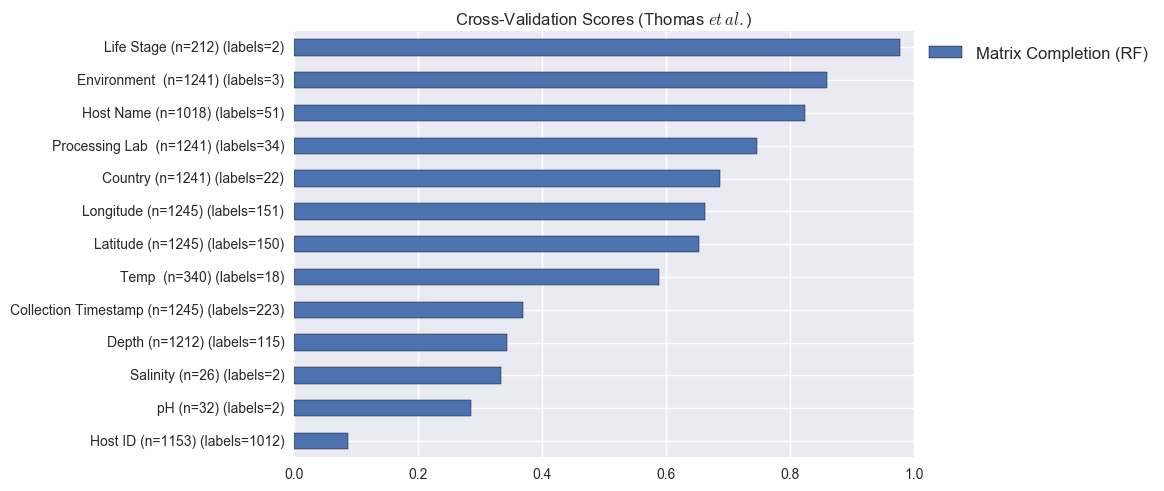

In [6]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
spongescores.columns=['Matrix Completion (RF)']
spongescores.sort_values(['Matrix Completion (RF)'], ascending = [True], inplace = True)
#rename a few
spongescores.plot(kind='barh',title='Cross-Validation Scores (Thomas $et \, al.$)',xlim=(0,1),ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylabel('')
plt.show()

# Extract Important OTUs (features) for sponge life stage

### Now that you know life stage is an important category you would like to find out what pattern of OTUs best explain that change at each point in your mapping data. Here we plot the pattern that the machine learning found at each life stage. The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.

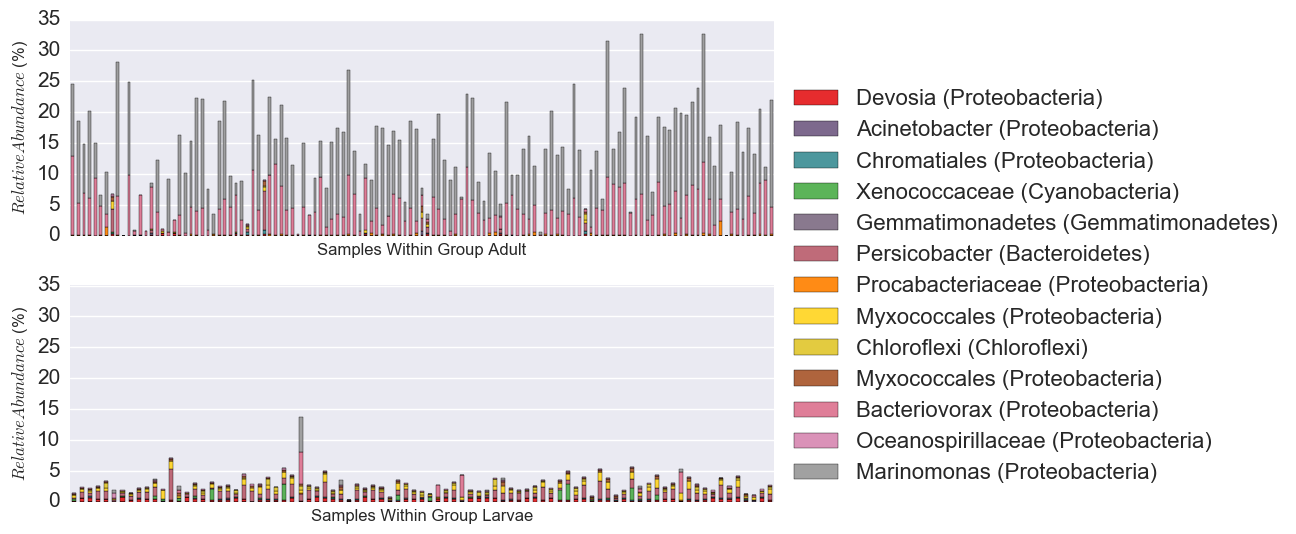

In [24]:
#get important features
n=13#this will be the number of OTUs that are in the figure 
niche='Life Stage'#this will determine which mapping catagory to use
sfotus,sfmappingdf=fetch.matchtable(otutabledf,mappingdf.T[~mappingdf.T[niche].isin(['Unknown','adult'])].T)
important_otus=untangle.features_ml(sfotus,sfmappingdf.T,niche,complete=True,iteration=100)
#plot
fig=untangle.feature_vis(sfotus,sfmappingdf,list(important_otus.index[:n]),niche,taxnames)
plt.show()

## This can help guide the biology quickly to important environmental factors or patient data. It can also quickly extract OTU pattern that is predictive of the identified states.

## For example here we find that the OTUs that best differentiate the samples between adult sponges and larvae are generally in the phylum Proteobacteria. We can also see that the Proteobacteria of Marinomonas and Oceanospirillaceae are more abundant in adult sponges. While the larvae sponges have a diverse group of Proteobacteria and Chloroflexi that differentiate them.

## Now we can visualize the clustering in clr-PCA and extract variant OTUs along the axis for Solid Food 

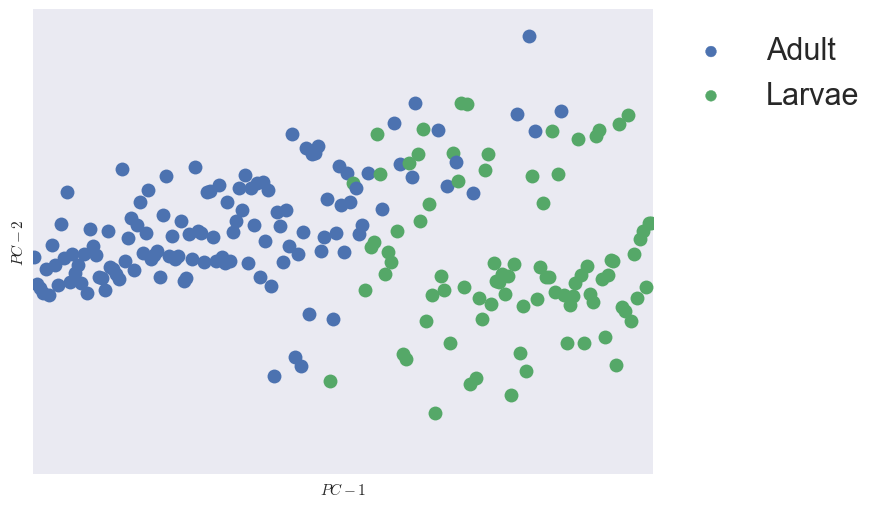

In [25]:
#compare to PCoA
fig,OTUweightsPC1,OTUweightsPC2=untangle.pca_plot(sfotus,sfmappingdf,niche)
plt.show()

## Learning Bacteria that Cause Variance Along Axis for life stage

#### Recovering information about features from PCA eigenvectors  


### Suppose we would like to see how the bacteria change along this first axis of pH since our machine learning identified that as the best category from the metadata.

### If the gradient change is along that axis we can then say what bacteria changes the most along that axis.

### The principal components are a linear combination of original features in N dimensional space

### $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

#### Where $\beta_{N}^{j}$ are weights and $X_{N}$ is the original variables

#### Therefore the coefficients are the transform of an identity matrix of shape X

#### Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weights pertaining to each principal component $ PC^{j}$. 

#### In other words we can examine the weights on each OTU or bacteria that best explain the variance of each axis in our PCA graph. 

# This time we do want to use PC-1

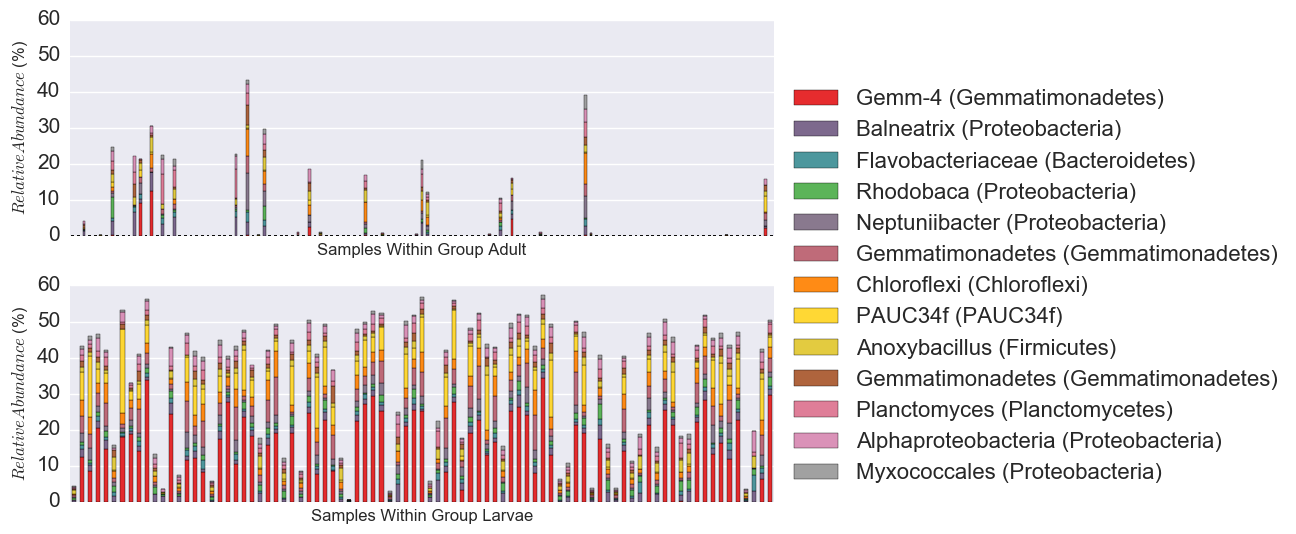

In [26]:
#plot 
n=13 #this will tell the command how many bacteria to plot
fig=untangle.feature_vis(sfotus,sfmappingdf,list(OTUweightsPC1.index[:n]),niche,taxnames)
plt.show()

## Having direct OTU based explanation to the PCA axis we can see those OTUs that vary the most along the axis.

## For example here we find that the OTUs that best differentiate the samples between infants who have solid food and those who have not are in the phylum Gemmatimonadete in larvae sponges.

In [214]:
plt.close('all')